In [68]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current GPU device: {torch.cuda.get_device_name()}")

PyTorch version: 2.6.0+cu126
CUDA available: True
Current GPU device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


***GOOGLE STOCK DATA***

In [69]:
import yfinance as yf

# Fetch maximum available historical data for Google (GOOGL)
data_google = yf.download("GOOGL", period="max", interval="1d")

# Reset index to keep 'Date' as a column
data_google.reset_index(inplace=True)

# Display the first few rows
print(data_google.head())

# Verify the DataFrame structure and columns
print("Columns:", data_google.columns)


[*********************100%***********************]  1 of 1 completed

Price        Date     Close      High       Low      Open     Volume
Ticker                GOOGL     GOOGL     GOOGL     GOOGL      GOOGL
0      2004-08-19  2.499063  2.591713  2.389974  2.490595  893181924
1      2004-08-20  2.697563  2.716741  2.503048  2.515750  456686856
2      2004-08-23  2.724711  2.826327  2.715994  2.758334  365122512
3      2004-08-24  2.611887  2.779504  2.579509  2.770538  304946748
4      2004-08-25  2.640031  2.689843  2.587231  2.614129  183772044
Columns: MultiIndex([(  'Date',      ''),
            ( 'Close', 'GOOGL'),
            (  'High', 'GOOGL'),
            (   'Low', 'GOOGL'),
            (  'Open', 'GOOGL'),
            ('Volume', 'GOOGL')],
           names=['Price', 'Ticker'])


In [70]:
data_google = data_google.reset_index()
print(data_google['Date'].head())
data_google = data_google.reset_index()
data_google.columns = [col[0] if col[1] == '' else f"{col[0]}_{col[1]}" for col in data_google.columns]
if 'index' in data_google.columns:
    data_google = data_google.drop('index', axis=1)

# Create time index and add group identifier
data_google['time'] = range(len(data_google))
data_google['group'] = 'GOOGL'
data_google.columns

0   2004-08-19
1   2004-08-20
2   2004-08-23
3   2004-08-24
4   2004-08-25
Name: Date, dtype: datetime64[ns]


Index(['level_0', 'Date', 'Close_GOOGL', 'High_GOOGL', 'Low_GOOGL',
       'Open_GOOGL', 'Volume_GOOGL', 'time', 'group'],
      dtype='object')

In [71]:
# --- Data Quality Improvements Begin Here ---
import pandas as pd
# Check if 'Date' is in columns; if not, reset the index again
if 'Date' not in data_google.columns:
    data_google.reset_index(inplace=True)
    print("After resetting index, columns:", data_google.columns)

# Convert 'Date' to datetime
data_google['Date'] = pd.to_datetime(data_google['Date'])

# Continue with sorting and further cleaning
data_google.sort_values('Date', inplace=True)
data_google.reset_index(drop=True, inplace=True)

# Check for missing values and fill them
print("Missing values per column:")
print(data_google.isnull().sum())
data_google.fillna(method='ffill', inplace=True)

# Remove duplicate rows
data_google.drop_duplicates(inplace=True)

# Outlier removal (example for key numerical columns)
from scipy import stats
import numpy as np
for col in ['Close_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Open_GOOGL', 'Volume_GOOGL']:
    z_scores = np.abs(stats.zscore(data_google[col]))
    data_google = data_google[z_scores < 3]

# Feature engineering: Extract additional date features
data_google['year'] = data_google['Date'].dt.year
data_google['month'] = data_google['Date'].dt.month
data_google['day'] = data_google['Date'].dt.day
data_google['weekday'] = data_google['Date'].dt.weekday
data_google['month_sin'] = np.sin(2 * np.pi * data_google['month'] / 12)
data_google['month_cos'] = np.cos(2 * np.pi * data_google['month'] / 12)
data_google['weekday_sin'] = np.sin(2 * np.pi * data_google['weekday'] / 7)
data_google['weekday_cos'] = np.cos(2 * np.pi * data_google['weekday'] / 7)

# Normalize numerical features
from sklearn.preprocessing import MinMaxScaler
num_cols = ['Close_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Open_GOOGL', 'Volume_GOOGL']
scaler = MinMaxScaler()
data_google[num_cols] = scaler.fit_transform(data_google[num_cols])

print("Data quality improvements complete.")
print(data_google.head())


Missing values per column:
level_0         0
Date            0
Close_GOOGL     0
High_GOOGL      0
Low_GOOGL       0
Open_GOOGL      0
Volume_GOOGL    0
time            0
group           0
dtype: int64
Data quality improvements complete.
   level_0       Date  Close_GOOGL  High_GOOGL  Low_GOOGL  Open_GOOGL  \
1        1 2004-08-20     0.001127    0.000994   0.000214    0.000249   
2        2 2004-08-23     0.001275    0.001590   0.001388    0.001581   
3        3 2004-08-24     0.000660    0.001335   0.000636    0.001648   
4        4 2004-08-25     0.000813    0.000848   0.000678    0.000789   
5        5 2004-08-26     0.001073    0.000841   0.000786    0.000788   

   Volume_GOOGL  time  group  year  month  day  weekday  month_sin  month_cos  \
1      0.818469     1  GOOGL  2004      8   20        4  -0.866025       -0.5   
2      0.650953     2  GOOGL  2004      8   23        0  -0.866025       -0.5   
3      0.540862     3  GOOGL  2004      8   24        1  -0.866025       -0.5   

C:\Users\deepa\AppData\Local\Temp\ipykernel_10048\2683719975.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_google.fillna(method='ffill', inplace=True)


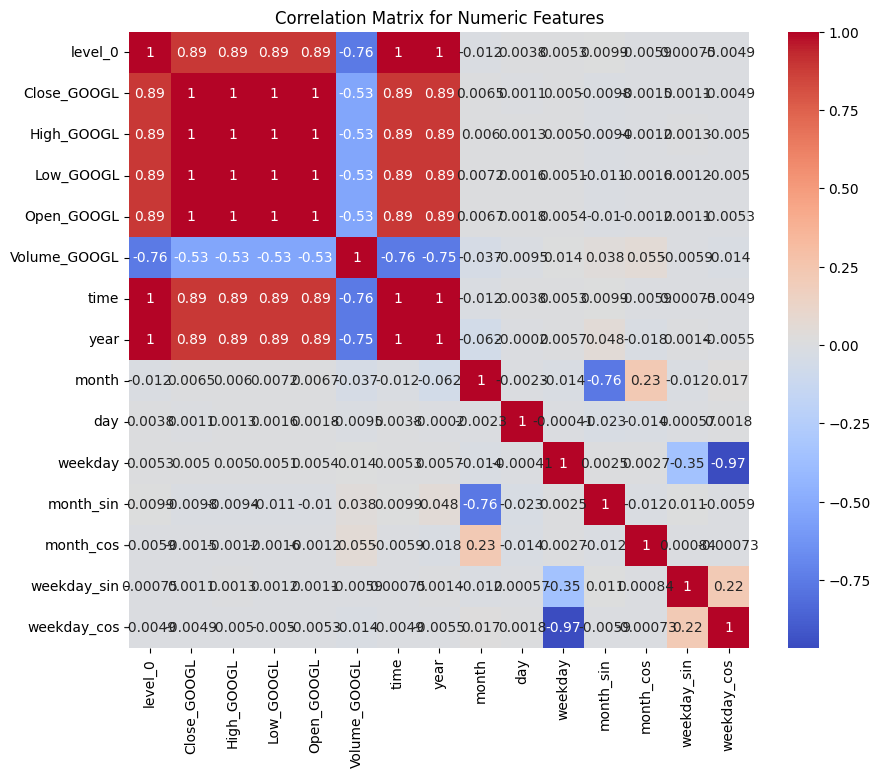

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns from the DataFrame
numeric_data = data_google.select_dtypes(include=[float, int])

# Compute the correlation matrix for numeric features
corr_matrix = numeric_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Numeric Features")
plt.show()


In [73]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# Define X (features) and y (target)
# Adjust feature_cols as needed, for example including engineered date features
X = data_google[['High_GOOGL', 'Low_GOOGL', 'Open_GOOGL', 'Volume_GOOGL', 'year', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']]
y = data_google['Close_GOOGL']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use Lasso with cross-validation to perform feature selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Examine coefficients
feature_importance = pd.Series(lasso.coef_, index=X.columns)
print("Lasso coefficients:\n", feature_importance)


Lasso coefficients:
 High_GOOGL      0.901793
Low_GOOGL       0.000000
Open_GOOGL      0.000000
Volume_GOOGL    0.000000
year            0.003449
month_sin      -0.000000
month_cos       0.000000
weekday_sin    -0.000000
weekday_cos     0.000000
dtype: float64


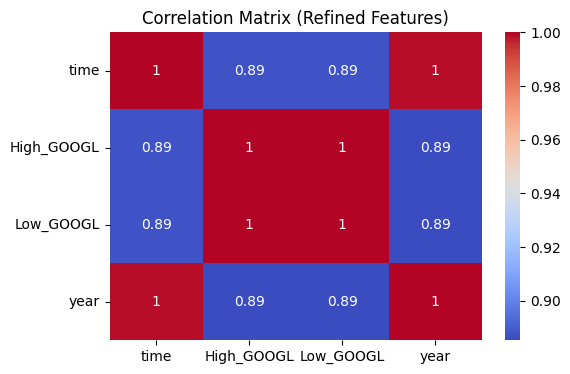

In [74]:
# Create a refined DataFrame with only the significant features:
selected_features = ['High_GOOGL', 'Low_GOOGL', 'year']  # Add any additional features if needed
refined_data = data_google[['Date', 'time', 'group'] + selected_features].copy()

# Optionally, if you want to keep some engineered date features (if they add value):
# refined_data = data_google[['Date', 'time', 'group', 'High_GOOGL', 'Low_GOOGL', 'year', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']]
import seaborn as sns
import matplotlib.pyplot as plt

numeric_refined = refined_data.select_dtypes(include=[float, int])
corr_matrix_refined = numeric_refined.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix_refined, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Refined Features)")
plt.show()


In [75]:
# Create a refined DataFrame with selected features:
selected_features = ['High_GOOGL', 'Low_GOOGL', 'year']
refined_data = data_google[['Date', 'time', 'group', 'Close_GOOGL'] + selected_features].copy()

# (Assuming the earlier cells already created the 'time', 'group', and 'year' features.)
# If not, ensure that in your preprocessing you generate these columns.

from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer

# Define the maximum encoder and prediction lengths
max_encoder_length = 120  # Use the past 120 days as input for each training sample
max_prediction_length = 30  # Predict the next 30 days

# Determine the training cutoff point ensuring each training sample has a full prediction window
training_cutoff = refined_data["time"].max() - max_prediction_length

# Create the TimeSeriesDataSet; with more historical data, the sliding window will yield more training samples.
training_dataset = TimeSeriesDataSet(
    refined_data[refined_data["time"] <= training_cutoff],
    time_idx="time",
    target="Close_GOOGL",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    static_reals=["year"],
    time_varying_known_categoricals=[],  
    time_varying_known_reals=["time"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["High_GOOGL", "Low_GOOGL", "Close_GOOGL"],
    target_normalizer=GroupNormalizer(
        groups=["group"],
        transformation="softplus"  # Adjust the transformation as needed
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True  # Allows missing timesteps if necessary
)

# Create the validation dataset from the full refined data (set predict=True and stop randomization)
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, 
    refined_data, 
    predict=True, 
    stop_randomization=True
)

# Create dataloaders
batch_size = 128  # Adjust based on your hardware capabilities
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


In [76]:
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss
import lightning.pytorch as pl
import torch

# Initialize the TFT model with tuned hyperparameters for improved performance
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.001,          # Lower learning rate for finer convergence
    hidden_size=128,              # Increased hidden size for higher model capacity
    attention_head_size=8,        # More attention heads to capture complex dependencies
    dropout=0.5,                  # Higher dropout to reduce overfitting
    hidden_continuous_size=64,    # Increased size for continuous variable processing
    loss=QuantileLoss(),          # Using QuantileLoss (standard for TFT forecasting)
    optimizer="adam",             # You may experiment with optimizers (e.g., Ranger) if desired
    reduce_on_plateau_patience=2, # Reduce learning rate sooner if validation loss plateaus
    weight_decay=1e-3             # Added L2 regularization to combat overfitting
)

# Print the model size (optional)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

# Set up PyTorch Lightning trainer with GPU support
trainer = pl.Trainer(
    max_epochs=100,  # Increase epochs to allow for more training (early stopping can be added if needed)
    accelerator="gpu" if torch.cuda.is_available() else "cpu",  # Use GPU if available
    devices=1,       # Use 1 GPU
    gradient_clip_val=0.5,  # Clip gradients to avoid explosion
    # Optionally, you can add callbacks (e.g., EarlyStopping, LearningRateMonitor) here
)

# Train the model
trainer.fit(tft, train_dataloader, val_dataloader)


c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
--------------------------------------------------

Number of parameters in network: 1103.7k
Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]

c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 37/37 [00:10<00:00,  3.46it/s, v_num=83, train_loss_step=0.0125, val_loss=0.0293, train_loss_epoch=0.0114] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 37/37 [00:10<00:00,  3.38it/s, v_num=83, train_loss_step=0.0125, val_loss=0.0293, train_loss_epoch=0.0114]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Actuals shape: (1,)
Predictions shape: (1,)

Metrics:
MSE: 0.0002
RMSE: 0.0154
MAE: 0.0154


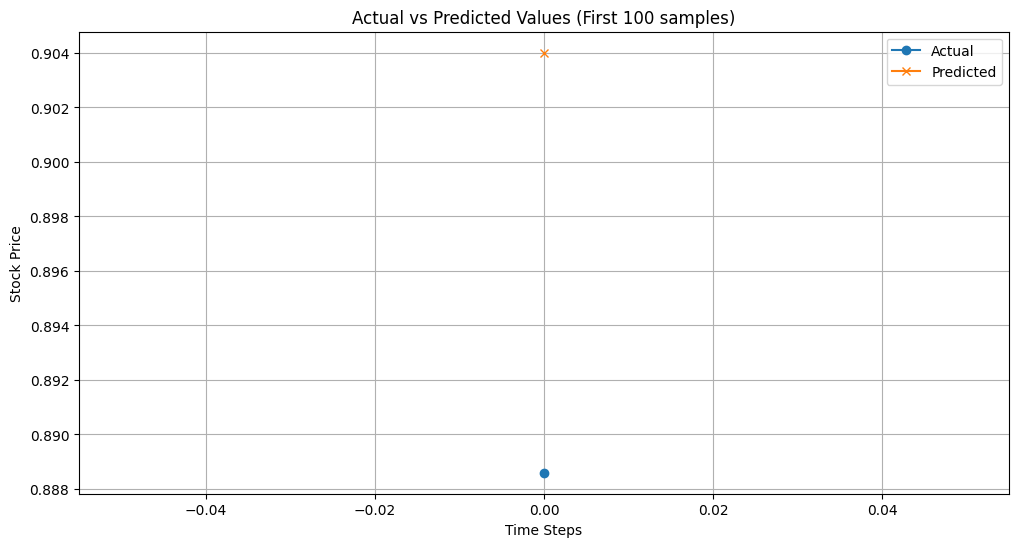

In [77]:
# Model evaluation
raw_predictions = tft.predict(val_dataloader)

# Get actual values
actuals = []
for x, y in val_dataloader:
    actuals.append(y[0][:, -1])  # Take the last time step
actuals = torch.cat(actuals)

# Get predictions (mean across samples)
predictions = raw_predictions.mean(1)  # Average across samples if using multiple quantiles

# Convert tensors to numpy arrays
actuals_np = actuals.cpu().numpy()
predictions_np = predictions.cpu().numpy()

# Ensure shapes match
print(f"Actuals shape: {actuals_np.shape}")
print(f"Predictions shape: {predictions_np.shape}")

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(actuals_np, predictions_np)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals_np, predictions_np)

print(f"\nMetrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Visualize predictions vs actuals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actuals_np[:100], label='Actual', marker='o')
plt.plot(predictions_np[:100], label='Predicted', marker='x')
plt.legend()
plt.title('Actual vs Predicted Values (First 100 samples)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

# Save metrics to a file
import json
metrics = {
    'mse': float(mse),
    'rmse': float(rmse),
    'mae': float(mae)
}

with open('model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

In [78]:
import torch

# Define the path where the model will be saved
model_path = "C:/Users/deepa/OneDrive/Documents/Project Documents/Stock_Market_Forecasting_using_DeepLearning/WebApp/Models/model_googl.pth"

# Save the trained model's state dictionaray
torch.save(tft.state_dict(), model_path)

print(f"Model saved successfully at {model_path}")


Model saved successfully at C:/Users/deepa/OneDrive/Documents/Project Documents/Stock_Market_Forecasting_using_DeepLearning/WebApp/Models/model_googl.pth


***APPLE STOCK DATA***

In [79]:
import yfinance as yf

# Fetch maximum available historical data for Google (GOOGL)
data_apple = yf.download("AAPL", period="max", interval="1d")

# Reset index to keep 'Date' as a column
data_apple.reset_index(inplace=True)

# Display the first few rows
print(data_apple.head())

# Verify the DataFrame structure and columns
print("Columns:", data_apple.columns)


[*********************100%***********************]  1 of 1 completed

Price        Date     Close      High       Low      Open     Volume
Ticker                 AAPL      AAPL      AAPL      AAPL       AAPL
0      1980-12-12  0.098726  0.099155  0.098726  0.098726  469033600
1      1980-12-15  0.093575  0.094005  0.093575  0.094005  175884800
2      1980-12-16  0.086707  0.087136  0.086707  0.087136  105728000
3      1980-12-17  0.088853  0.089282  0.088853  0.088853   86441600
4      1980-12-18  0.091429  0.091858  0.091429  0.091429   73449600
Columns: MultiIndex([(  'Date',     ''),
            ( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [80]:
data_apple = data_apple.reset_index()
print(data_apple['Date'].head())
data_apple = data_apple.reset_index()
data_apple.columns = [col[0] if col[1] == '' else f"{col[0]}_{col[1]}" for col in data_apple.columns]
if 'index' in data_apple.columns:
    data_apple = data_apple.drop('index', axis=1)

# Create time index and add group identifier
data_apple['time'] = range(len(data_apple))
data_apple['group'] = 'AAPL'
data_apple.columns

0   1980-12-12
1   1980-12-15
2   1980-12-16
3   1980-12-17
4   1980-12-18
Name: Date, dtype: datetime64[ns]


Index(['level_0', 'Date', 'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL',
       'Volume_AAPL', 'time', 'group'],
      dtype='object')

In [81]:
# --- Data Quality Improvements Begin Here ---
import pandas as pd
# Check if 'Date' is in columns; if not, reset the index again
if 'Date' not in data_apple.columns:
    data_apple.reset_index(inplace=True)
    print("After resetting index, columns:", data_apple.columns)

# Convert 'Date' to datetime
data_apple['Date'] = pd.to_datetime(data_apple['Date'])

# Continue with sorting and further cleaning
data_apple.sort_values('Date', inplace=True)
data_apple.reset_index(drop=True, inplace=True)

# Check for missing values and fill them
print("Missing values per column:")
print(data_apple.isnull().sum())
data_apple.fillna(method='ffill', inplace=True)

# Remove duplicate rows
data_apple.drop_duplicates(inplace=True)

# Outlier removal (example for key numerical columns)
from scipy import stats
import numpy as np
for col in ['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL']:
    z_scores = np.abs(stats.zscore(data_apple[col]))
    data_apple = data_apple[z_scores < 3]

# Feature engineering: Extract additional date features
data_apple['year'] = data_apple['Date'].dt.year
data_apple['month'] = data_apple['Date'].dt.month
data_apple['day'] = data_apple['Date'].dt.day
data_apple['weekday'] = data_apple['Date'].dt.weekday
data_apple['month_sin'] = np.sin(2 * np.pi * data_apple['month'] / 12)
data_apple['month_cos'] = np.cos(2 * np.pi * data_apple['month'] / 12)
data_apple['weekday_sin'] = np.sin(2 * np.pi * data_apple['weekday'] / 7)
data_apple['weekday_cos'] = np.cos(2 * np.pi * data_apple['weekday'] / 7)

# Normalize numerical features
from sklearn.preprocessing import MinMaxScaler
num_cols = ['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL']
scaler = MinMaxScaler()
data_apple[num_cols] = scaler.fit_transform(data_apple[num_cols])

print("Data quality improvements complete.")
print(data_apple.head())


Missing values per column:
level_0        0
Date           0
Close_AAPL     0
High_AAPL      0
Low_AAPL       0
Open_AAPL      0
Volume_AAPL    0
time           0
group          0
dtype: int64
Data quality improvements complete.
   level_0       Date  Close_AAPL  High_AAPL  Low_AAPL  Open_AAPL  \
0        0 1980-12-12    0.001179   0.001169  0.001196   0.001187   
1        1 1980-12-15    0.001080   0.001070  0.001095   0.001095   
2        2 1980-12-16    0.000947   0.000939  0.000960   0.000960   
3        3 1980-12-17    0.000988   0.000980  0.001002   0.000993   
4        4 1980-12-18    0.001038   0.001029  0.001053   0.001044   

   Volume_AAPL  time group  year  month  day  weekday     month_sin  \
0     0.339021     0  AAPL  1980     12   12        4 -2.449294e-16   
1     0.127131     1  AAPL  1980     12   15        0 -2.449294e-16   
2     0.076421     2  AAPL  1980     12   16        1 -2.449294e-16   
3     0.062481     3  AAPL  1980     12   17        2 -2.449294e-16   
4

C:\Users\deepa\AppData\Local\Temp\ipykernel_10048\1393882256.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_apple.fillna(method='ffill', inplace=True)


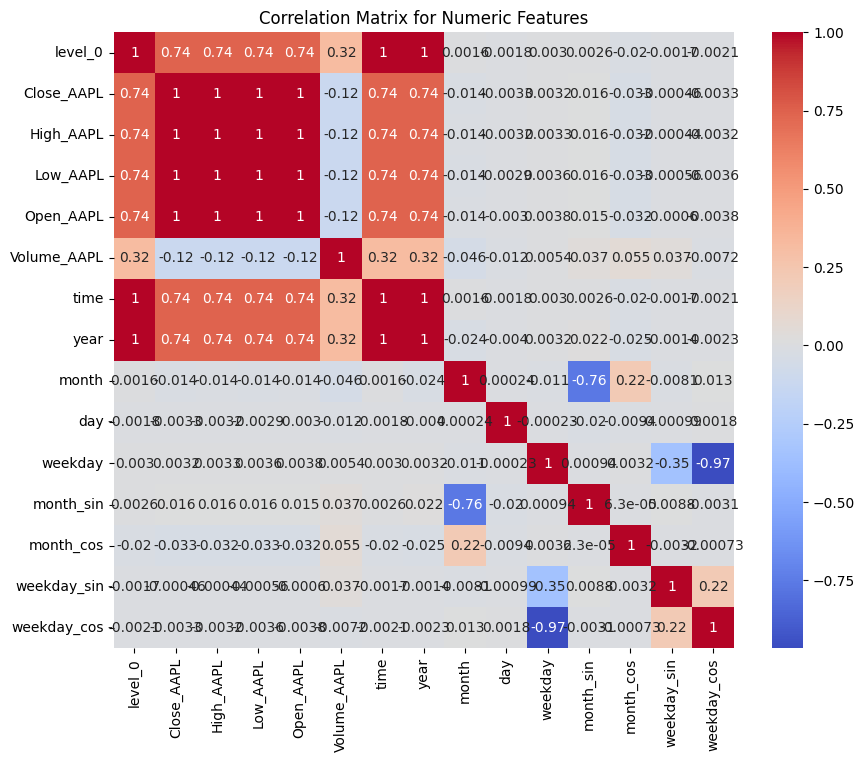

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns from the DataFrame
numeric_data = data_apple.select_dtypes(include=[float, int])

# Compute the correlation matrix for numeric features
corr_matrix = numeric_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Numeric Features")
plt.show()


In [83]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# Define X (features) and y (target)
# Adjust feature_cols as needed, for example including engineered date features
X = data_apple[['High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL', 'year', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']]
y = data_apple['Close_AAPL']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use Lasso with cross-validation to perform feature selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Examine coefficients
feature_importance = pd.Series(lasso.coef_, index=X.columns)
print("Lasso coefficients:\n", feature_importance)


Lasso coefficients:
 High_AAPL      0.420091
Low_AAPL       0.272068
Open_AAPL      0.222787
Volume_AAPL   -0.000000
year           0.001180
month_sin     -0.000000
month_cos     -0.000000
weekday_sin   -0.000000
weekday_cos   -0.000000
dtype: float64


c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.997e-02, tolerance: 3.757e-02
  model = cd_fast.enet_coordinate_descent(


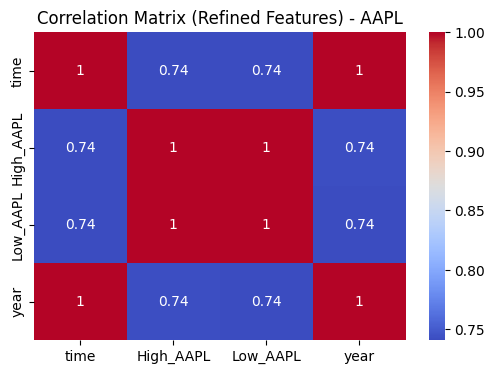

In [84]:
# Select refined features
selected_features = ['High_AAPL', 'Low_AAPL', 'year']
refined_data = data_apple[['Date', 'time', 'group'] + selected_features].copy()

import seaborn as sns
import matplotlib.pyplot as plt

numeric_refined = refined_data.select_dtypes(include=[float, int])
corr_matrix_refined = numeric_refined.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix_refined, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Refined Features) - AAPL")
plt.show()


In [85]:
# Create a refined DataFrame with selected features:
selected_features = ['High_AAPL', 'Low_AAPL', 'year']
refined_data = data_apple[['Date', 'time', 'group', 'Close_AAPL'] + selected_features].copy()

# (Assuming the earlier cells already created the 'time', 'group', and 'year' features.)
# If not, ensure that in your preprocessing you generate these columns.

from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer

# Define the maximum encoder and prediction lengths
max_encoder_length = 120  # Use the past 120 days as input for each training sample
max_prediction_length = 30  # Predict the next 30 days

# Determine the training cutoff point ensuring each training sample has a full prediction window
training_cutoff = refined_data["time"].max() - max_prediction_length

# Create the TimeSeriesDataSet; with more historical data, the sliding window will yield more training samples.
training_dataset = TimeSeriesDataSet(
    refined_data[refined_data["time"] <= training_cutoff],
    time_idx="time",
    target="Close_AAPL",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    static_reals=["year"],
    time_varying_known_categoricals=[],  
    time_varying_known_reals=["time"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["High_AAPL", "Low_AAPL", "Close_AAPL"],
    target_normalizer=GroupNormalizer(
        groups=["group"],
        transformation="softplus"  # Adjust the transformation as needed
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True  # Allows missing timesteps if necessary
)

# Create the validation dataset from the full refined data (set predict=True and stop randomization)
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, 
    refined_data, 
    predict=True, 
    stop_randomization=True
)

# Create dataloaders
batch_size = 128  # Adjust based on your hardware capabilities
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


In [86]:
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss
import lightning.pytorch as pl
import torch

# Initialize the TFT model with tuned hyperparameters for improved performance
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.001,          # Lower learning rate for finer convergence
    hidden_size=128,              # Increased hidden size for higher model capacity
    attention_head_size=8,        # More attention heads to capture complex dependencies
    dropout=0.5,                  # Higher dropout to reduce overfitting
    hidden_continuous_size=64,    # Increased size for continuous variable processing
    loss=QuantileLoss(),          # Using QuantileLoss (standard for TFT forecasting)
    optimizer="adam",             # You may experiment with optimizers (e.g., Ranger) if desired
    reduce_on_plateau_patience=2, # Reduce learning rate sooner if validation loss plateaus
    weight_decay=1e-3             # Added L2 regularization to combat overfitting
)

# Print the model size (optional)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

# Set up PyTorch Lightning trainer with GPU support
trainer = pl.Trainer(
    max_epochs=100,  # Increase epochs to allow for more training (early stopping can be added if needed)
    accelerator="gpu" if torch.cuda.is_available() else "cpu",  # Use GPU if available
    devices=1,       # Use 1 GPU
    gradient_clip_val=0.5,  # Clip gradients to avoid explosion
    # Optionally, you can add callbacks (e.g., EarlyStopping, LearningRateMonitor) here
)

# Train the model
trainer.fit(tft, train_dataloader, val_dataloader)


c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
--------------------------------------------------

Number of parameters in network: 1103.7k
Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.41it/s]

c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 71/71 [00:20<00:00,  3.41it/s, v_num=85, train_loss_step=0.0076, val_loss=0.055, train_loss_epoch=0.00745]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 71/71 [00:21<00:00,  3.33it/s, v_num=85, train_loss_step=0.0076, val_loss=0.055, train_loss_epoch=0.00745]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Actuals shape: (1,)
Predictions shape: (1,)

Metrics:
MSE: 0.0151
RMSE: 0.1230
MAE: 0.1230


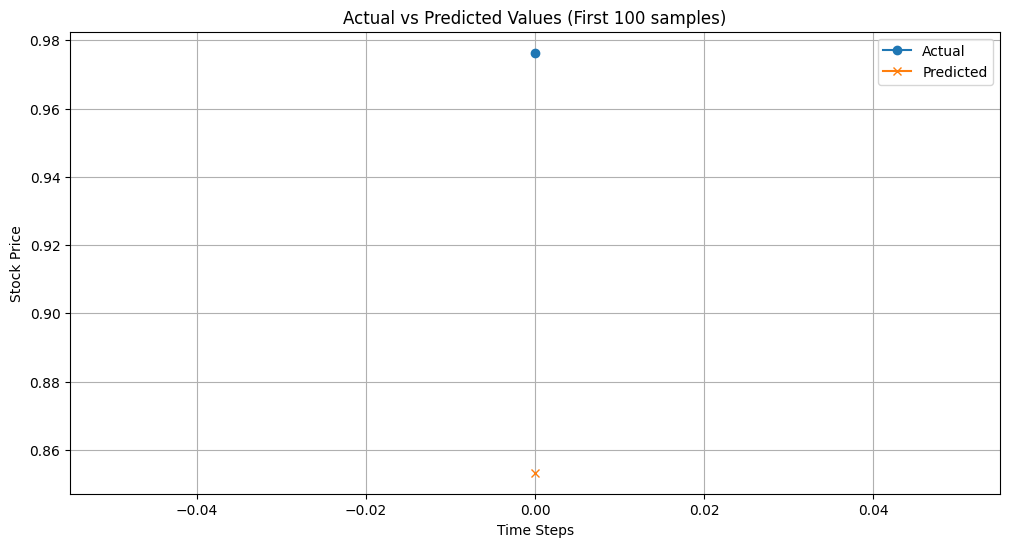

In [87]:
# Model evaluation
raw_predictions = tft.predict(val_dataloader)

# Get actual values
actuals = []
for x, y in val_dataloader:
    actuals.append(y[0][:, -1])  # Take the last time step
actuals = torch.cat(actuals)

# Get predictions (mean across samples)
predictions = raw_predictions.mean(1)  # Average across samples if using multiple quantiles

# Convert tensors to numpy arrays
actuals_np = actuals.cpu().numpy()
predictions_np = predictions.cpu().numpy()

# Ensure shapes match
print(f"Actuals shape: {actuals_np.shape}")
print(f"Predictions shape: {predictions_np.shape}")

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(actuals_np, predictions_np)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals_np, predictions_np)

print(f"\nMetrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Visualize predictions vs actuals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actuals_np[:100], label='Actual', marker='o')
plt.plot(predictions_np[:100], label='Predicted', marker='x')
plt.legend()
plt.title('Actual vs Predicted Values (First 100 samples)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

# Save metrics to a file
import json
metrics = {
    'mse': float(mse),
    'rmse': float(rmse),
    'mae': float(mae)
}

with open('model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

In [88]:
import torch

# Define the path where the model will be saved
model_path = "C:/Users/deepa/OneDrive/Documents/Project Documents/Stock_Market_Forecasting_using_DeepLearning/WebApp/Models/model_aapl.pth"

# Save the trained model's state dictionaray
torch.save(tft.state_dict(), model_path)

print(f"Model saved successfully at {model_path}")


Model saved successfully at C:/Users/deepa/OneDrive/Documents/Project Documents/Stock_Market_Forecasting_using_DeepLearning/WebApp/Models/model_aapl.pth


***AMAZON STOCK DATA***

In [89]:
import yfinance as yf

# Fetch maximum available historical data for Google (GOOGL)
data_amazon = yf.download("AMZN", period="max", interval="1d")

# Reset index to keep 'Date' as a column
data_amazon.reset_index(inplace=True)

# Display the first few rows
print(data_amazon.head())

# Verify the DataFrame structure and columns
print("Columns:", data_amazon.columns)


[*********************100%***********************]  1 of 1 completed

Price        Date     Close      High       Low      Open      Volume
Ticker                 AMZN      AMZN      AMZN      AMZN        AMZN
0      1997-05-15  0.097917  0.125000  0.096354  0.121875  1443120000
1      1997-05-16  0.086458  0.098958  0.085417  0.098438   294000000
2      1997-05-19  0.085417  0.088542  0.081250  0.088021   122136000
3      1997-05-20  0.081771  0.087500  0.081771  0.086458   109344000
4      1997-05-21  0.071354  0.082292  0.068750  0.081771   377064000
Columns: MultiIndex([(  'Date',     ''),
            ( 'Close', 'AMZN'),
            (  'High', 'AMZN'),
            (   'Low', 'AMZN'),
            (  'Open', 'AMZN'),
            ('Volume', 'AMZN')],
           names=['Price', 'Ticker'])


In [90]:
data_amazon = data_amazon.reset_index()
print(data_amazon['Date'].head())
data_amazon = data_amazon.reset_index()
data_amazon.columns = [col[0] if col[1] == '' else f"{col[0]}_{col[1]}" for col in data_amazon.columns]
if 'index' in data_amazon.columns:
    data_amazon = data_amazon.drop('index', axis=1)

# Create time index and add group identifier
data_amazon['time'] = range(len(data_amazon))
data_amazon['group'] = 'AMZN'
data_amazon.columns

0   1997-05-15
1   1997-05-16
2   1997-05-19
3   1997-05-20
4   1997-05-21
Name: Date, dtype: datetime64[ns]


Index(['level_0', 'Date', 'Close_AMZN', 'High_AMZN', 'Low_AMZN', 'Open_AMZN',
       'Volume_AMZN', 'time', 'group'],
      dtype='object')

In [91]:
# --- Data Quality Improvements Begin Here ---
import pandas as pd
# Check if 'Date' is in columns; if not, reset the index again
if 'Date' not in data_amazon.columns:
    data_amazon.reset_index(inplace=True)
    print("After resetting index, columns:", data_amazon.columns)

# Convert 'Date' to datetime
data_amazon['Date'] = pd.to_datetime(data_amazon['Date'])

# Continue with sorting and further cleaning
data_amazon.sort_values('Date', inplace=True)
data_amazon.reset_index(drop=True, inplace=True)

# Check for missing values and fill them
print("Missing values per column:")
print(data_amazon.isnull().sum())
data_amazon.fillna(method='ffill', inplace=True)

# Remove duplicate rows
data_amazon.drop_duplicates(inplace=True)

# Outlier removal (example for key numerical columns)
from scipy import stats
import numpy as np
for col in ['Close_AMZN', 'High_AMZN', 'Low_AMZN', 'Open_AMZN', 'Volume_AMZN']:
    z_scores = np.abs(stats.zscore(data_amazon[col]))
    data_amazon = data_amazon[z_scores < 3]

# Feature engineering: Extract additional date features
data_amazon['year'] = data_amazon['Date'].dt.year
data_amazon['month'] = data_amazon['Date'].dt.month
data_amazon['day'] = data_amazon['Date'].dt.day
data_amazon['weekday'] = data_amazon['Date'].dt.weekday
data_amazon['month_sin'] = np.sin(2 * np.pi * data_amazon['month'] / 12)
data_amazon['month_cos'] = np.cos(2 * np.pi * data_amazon['month'] / 12)
data_amazon['weekday_sin'] = np.sin(2 * np.pi * data_amazon['weekday'] / 7)
data_amazon['weekday_cos'] = np.cos(2 * np.pi * data_amazon['weekday'] / 7)

# Normalize numerical features
from sklearn.preprocessing import MinMaxScaler
num_cols = ['Close_AMZN', 'High_AMZN', 'Low_AMZN', 'Open_AMZN', 'Volume_AMZN']
scaler = MinMaxScaler()
data_amazon[num_cols] = scaler.fit_transform(data_amazon[num_cols])

print("Data quality improvements complete.")
print(data_amazon.head())


Missing values per column:
level_0        0
Date           0
Close_AMZN     0
High_AMZN      0
Low_AMZN       0
Open_AMZN      0
Volume_AMZN    0
time           0
group          0
dtype: int64
Data quality improvements complete.
   level_0       Date  Close_AMZN  High_AMZN  Low_AMZN  Open_AMZN  \
1        1 1997-05-16    0.000080   0.000127  0.000097   0.000136   
2        2 1997-05-19    0.000075   0.000077  0.000076   0.000086   
3        3 1997-05-20    0.000058   0.000072  0.000079   0.000078   
4        4 1997-05-21    0.000007   0.000047  0.000015   0.000055   
5        5 1997-05-22    0.000000   0.000000  0.000000   0.000008   

   Volume_AMZN  time group  year  month  day  weekday  month_sin  month_cos  \
1     0.529605     1  AMZN  1997      5   16        4        0.5  -0.866025   
2     0.209401     2  AMZN  1997      5   19        0        0.5  -0.866025   
3     0.185567     3  AMZN  1997      5   20        1        0.5  -0.866025   
4     0.684364     4  AMZN  1997      5 

C:\Users\deepa\AppData\Local\Temp\ipykernel_10048\2574235969.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_amazon.fillna(method='ffill', inplace=True)


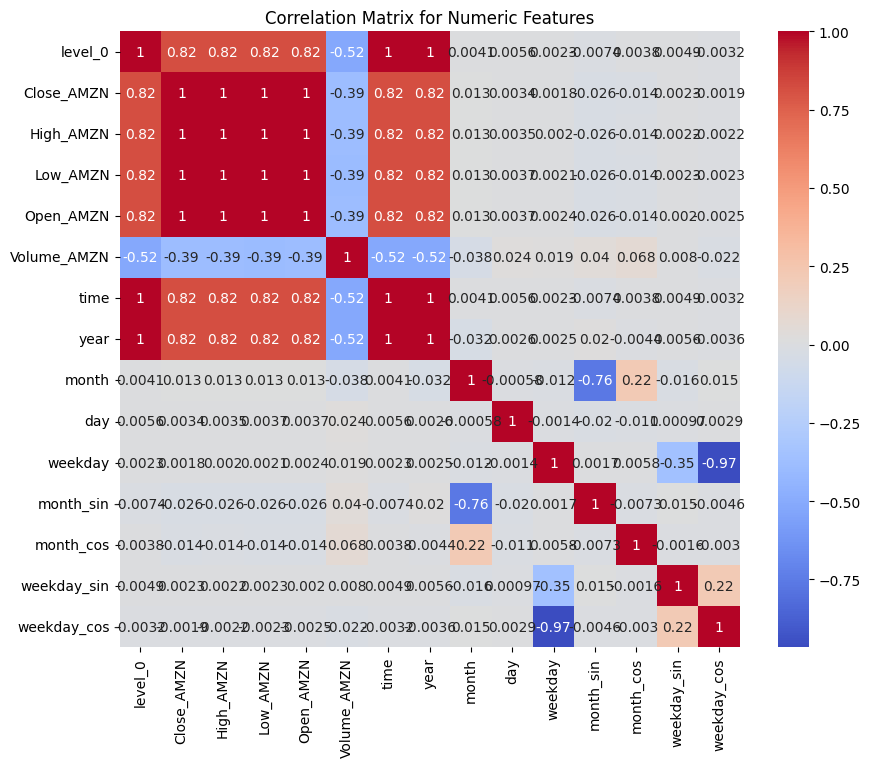

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns from the DataFrame
numeric_data = data_amazon.select_dtypes(include=[float, int])

# Compute the correlation matrix for numeric features
corr_matrix = numeric_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Numeric Features")
plt.show()


In [93]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

# Define X (features) and y (target)
# Adjust feature_cols as needed, for example including engineered date features
X = data_amazon[['High_AMZN', 'Low_AMZN', 'Open_AMZN', 'Volume_AMZN', 'year', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']]
y = data_amazon['Close_AMZN']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use Lasso with cross-validation to perform feature selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Examine coefficients
feature_importance = pd.Series(lasso.coef_, index=X.columns)
print("Lasso coefficients:\n", feature_importance)


Lasso coefficients:
 High_AMZN      0.783129
Low_AMZN       0.141703
Open_AMZN      0.000000
Volume_AMZN    0.000000
year           0.001987
month_sin     -0.000000
month_cos     -0.000000
weekday_sin   -0.000000
weekday_cos    0.000000
dtype: float64


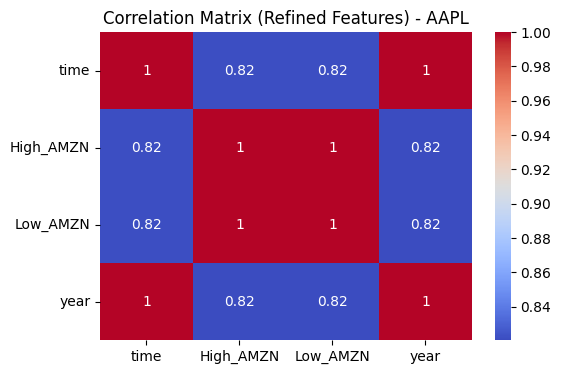

In [94]:
# Select refined features
selected_features = ['High_AMZN', 'Low_AMZN', 'year']
refined_data = data_amazon[['Date', 'time', 'group'] + selected_features].copy()

import seaborn as sns
import matplotlib.pyplot as plt

numeric_refined = refined_data.select_dtypes(include=[float, int])
corr_matrix_refined = numeric_refined.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix_refined, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (Refined Features) - AAPL")
plt.show()


In [95]:
# Create a refined DataFrame with selected features:
selected_features = ['High_AMZN', 'Low_AMZN', 'year']
refined_data = data_amazon[['Date', 'time', 'group', 'Close_AMZN'] + selected_features].copy()

# (Assuming the earlier cells already created the 'time', 'group', and 'year' features.)
# If not, ensure that in your preprocessing you generate these columns.

from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer

# Define the maximum encoder and prediction lengths
max_encoder_length = 120  # Use the past 120 days as input for each training sample
max_prediction_length = 30  # Predict the next 30 days

# Determine the training cutoff point ensuring each training sample has a full prediction window
training_cutoff = refined_data["time"].max() - max_prediction_length

# Create the TimeSeriesDataSet; with more historical data, the sliding window will yield more training samples.
training_dataset = TimeSeriesDataSet(
    refined_data[refined_data["time"] <= training_cutoff],
    time_idx="time",
    target="Close_AMZN",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    static_reals=["year"],
    time_varying_known_categoricals=[],  
    time_varying_known_reals=["time"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["High_AMZN", "Low_AMZN", "Close_AMZN"],
    target_normalizer=GroupNormalizer(
        groups=["group"],
        transformation="softplus"  # Adjust the transformation as needed
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True  # Allows missing timesteps if necessary
)

# Create the validation dataset from the full refined data (set predict=True and stop randomization)
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, 
    refined_data, 
    predict=True, 
    stop_randomization=True
)

# Create dataloaders
batch_size = 128  # Adjust based on your hardware capabilities
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


In [96]:
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss
import lightning.pytorch as pl
import torch

# Initialize the TFT model with tuned hyperparameters for improved performance
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.001,          # Lower learning rate for finer convergence
    hidden_size=128,              # Increased hidden size for higher model capacity
    attention_head_size=8,        # More attention heads to capture complex dependencies
    dropout=0.5,                  # Higher dropout to reduce overfitting
    hidden_continuous_size=64,    # Increased size for continuous variable processing
    loss=QuantileLoss(),          # Using QuantileLoss (standard for TFT forecasting)
    optimizer="adam",             # You may experiment with optimizers (e.g., Ranger) if desired
    reduce_on_plateau_patience=2, # Reduce learning rate sooner if validation loss plateaus
    weight_decay=1e-3             # Added L2 regularization to combat overfitting
)

# Print the model size (optional)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

# Set up PyTorch Lightning trainer with GPU support
trainer = pl.Trainer(
    max_epochs=100,  # Increase epochs to allow for more training (early stopping can be added if needed)
    accelerator="gpu" if torch.cuda.is_available() else "cpu",  # Use GPU if available
    devices=1,       # Use 1 GPU
    gradient_clip_val=0.5,  # Clip gradients to avoid explosion
    # Optionally, you can add callbacks (e.g., EarlyStopping, LearningRateMonitor) here
)

# Train the model
trainer.fit(tft, train_dataloader, val_dataloader)


c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
--------------------------------------------------

Number of parameters in network: 1103.7k
                                                                           

c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 50/50 [00:14<00:00,  3.45it/s, v_num=87, train_loss_step=0.013, val_loss=0.0446, train_loss_epoch=0.0127]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 50/50 [00:14<00:00,  3.39it/s, v_num=87, train_loss_step=0.013, val_loss=0.0446, train_loss_epoch=0.0127]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Actuals shape: (1,)
Predictions shape: (1,)

Metrics:
MSE: 0.0025
RMSE: 0.0505
MAE: 0.0505


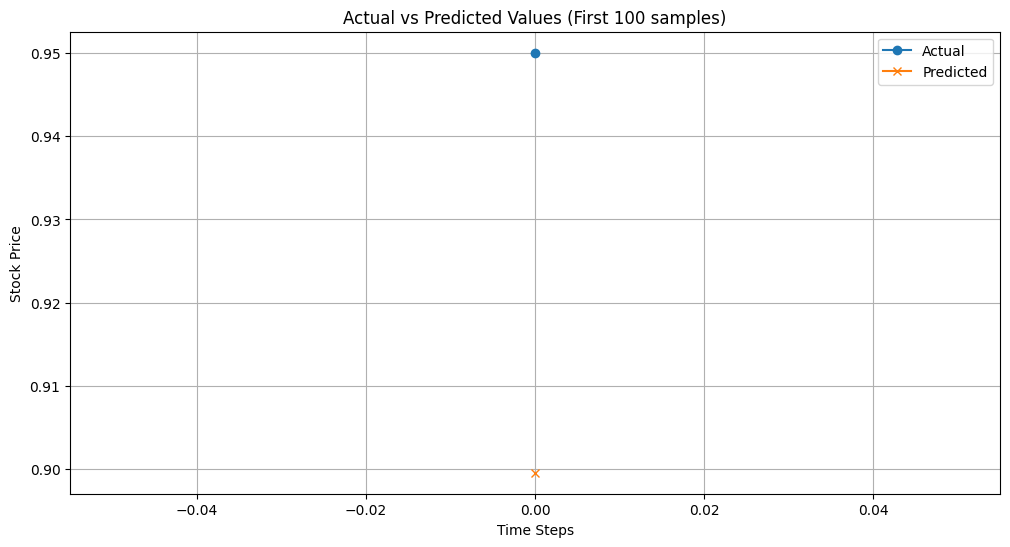

In [97]:
# Model evaluation
raw_predictions = tft.predict(val_dataloader)

# Get actual values
actuals = []
for x, y in val_dataloader:
    actuals.append(y[0][:, -1])  # Take the last time step
actuals = torch.cat(actuals)

# Get predictions (mean across samples)
predictions = raw_predictions.mean(1)  # Average across samples if using multiple quantiles

# Convert tensors to numpy arrays
actuals_np = actuals.cpu().numpy()
predictions_np = predictions.cpu().numpy()

# Ensure shapes match
print(f"Actuals shape: {actuals_np.shape}")
print(f"Predictions shape: {predictions_np.shape}")

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(actuals_np, predictions_np)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals_np, predictions_np)

print(f"\nMetrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Visualize predictions vs actuals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actuals_np[:100], label='Actual', marker='o')
plt.plot(predictions_np[:100], label='Predicted', marker='x')
plt.legend()
plt.title('Actual vs Predicted Values (First 100 samples)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

# Save metrics to a file
import json
metrics = {
    'mse': float(mse),
    'rmse': float(rmse),
    'mae': float(mae)
}

with open('model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

In [98]:
# Save Amazon model
model_path = "C:/Users/deepa/OneDrive/Documents/Project Documents/Stock_Market_Forecasting_using_DeepLearning/WebApp/Models/model_amzn.pth"
torch.save(tft.state_dict(), model_path)
print(f"Model saved successfully at {model_path}")

Model saved successfully at C:/Users/deepa/OneDrive/Documents/Project Documents/Stock_Market_Forecasting_using_DeepLearning/WebApp/Models/model_amzn.pth


***IBM Stock Data   ***

In [1]:
import yfinance as yf

# Fetch maximum available historical data for IBM
data_ibm = yf.download("IBM", period="max", interval="1d")

# Reset index to keep 'Date' as a column
data_ibm.reset_index(inplace=True)

# Display the first few rows
print(data_ibm.head())

# Verify the DataFrame structure and columns
print("Columns:", data_ibm.columns)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price        Date     Close      High       Low      Open  Volume
Ticker                  IBM       IBM       IBM       IBM     IBM
0      1962-01-02  1.491549  1.508498  1.491549  1.508498  407940
1      1962-01-03  1.504589  1.504589  1.491551  1.491551  305955
2      1962-01-04  1.489594  1.504588  1.488943  1.504588  274575
3      1962-01-05  1.460258  1.487638  1.457650  1.487638  384405
4      1962-01-08  1.432880  1.458956  1.421146  1.458956  572685
Columns: MultiIndex([(  'Date',    ''),
            ( 'Close', 'IBM'),
            (  'High', 'IBM'),
            (   'Low', 'IBM'),
            (  'Open', 'IBM'),
            ('Volume', 'IBM')],
           names=['Price', 'Ticker'])


In [2]:
data_ibm = data_ibm.reset_index()
print(data_ibm['Date'].head())
data_ibm = data_ibm.reset_index()
data_ibm.columns = [col[0] if col[1] == '' else f"{col[0]}_{col[1]}" for col in data_ibm.columns]
if 'index' in data_ibm.columns:
    data_ibm = data_ibm.drop('index', axis=1)

# Create time index and add group identifier
data_ibm['time'] = range(len(data_ibm))
data_ibm['group'] = 'IBM'
data_ibm.columns

0   1962-01-02
1   1962-01-03
2   1962-01-04
3   1962-01-05
4   1962-01-08
Name: Date, dtype: datetime64[ns]


Index(['level_0', 'Date', 'Close_IBM', 'High_IBM', 'Low_IBM', 'Open_IBM',
       'Volume_IBM', 'time', 'group'],
      dtype='object')

In [3]:
# --- Data Quality Improvements Begin Here ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# Check if 'Date' is in columns
if 'Date' not in data_ibm.columns:
    data_ibm.reset_index(inplace=True)

# Convert 'Date' to datetime
data_ibm['Date'] = pd.to_datetime(data_ibm['Date'])

# Sort and clean data
data_ibm.sort_values('Date', inplace=True)
data_ibm.reset_index(drop=True, inplace=True)

# Handle missing values
print("Missing values per column:")
print(data_ibm.isnull().sum())
data_ibm.fillna(method='ffill', inplace=True)

# Remove duplicates
data_ibm.drop_duplicates(inplace=True)

# Outlier removal
for col in ['Close_IBM', 'High_IBM', 'Low_IBM', 'Open_IBM', 'Volume_IBM']:
    z_scores = np.abs(stats.zscore(data_ibm[col]))
    data_ibm = data_ibm[z_scores < 3]

# Feature engineering
data_ibm['year'] = data_ibm['Date'].dt.year
data_ibm['month'] = data_ibm['Date'].dt.month
data_ibm['day'] = data_ibm['Date'].dt.day
data_ibm['weekday'] = data_ibm['Date'].dt.weekday
data_ibm['month_sin'] = np.sin(2 * np.pi * data_ibm['month'] / 12)
data_ibm['month_cos'] = np.cos(2 * np.pi * data_ibm['month'] / 12)
data_ibm['weekday_sin'] = np.sin(2 * np.pi * data_ibm['weekday'] / 7)
data_ibm['weekday_cos'] = np.cos(2 * np.pi * data_ibm['weekday'] / 7)

# Normalize numerical features
num_cols = ['Close_IBM', 'High_IBM', 'Low_IBM', 'Open_IBM', 'Volume_IBM']
scaler = MinMaxScaler()
data_ibm[num_cols] = scaler.fit_transform(data_ibm[num_cols])

print("Data quality improvements complete.")
print(data_ibm.head())

Missing values per column:
level_0       0
Date          0
Close_IBM     0
High_IBM      0
Low_IBM       0
Open_IBM      0
Volume_IBM    0
time          0
group         0
dtype: int64
Data quality improvements complete.
   level_0       Date  Close_IBM  High_IBM   Low_IBM  Open_IBM  Volume_IBM  \
0        0 1962-01-02   0.004272  0.004126  0.004426  0.004413    0.021566   
1        1 1962-01-03   0.004352  0.004102  0.004426  0.004308    0.016174   
2        2 1962-01-04   0.004260  0.004102  0.004410  0.004389    0.014516   
3        3 1962-01-05   0.004079  0.003998  0.004215  0.004283    0.020322   
4        4 1962-01-08   0.003910  0.003821  0.003987  0.004105    0.030275   

   time group  year  month  day  weekday  month_sin  month_cos  weekday_sin  \
0     0   IBM  1962      1    2        1        0.5   0.866025     0.781831   
1     1   IBM  1962      1    3        2        0.5   0.866025     0.974928   
2     2   IBM  1962      1    4        3        0.5   0.866025     0.43388

C:\Users\deepa\AppData\Local\Temp\ipykernel_23008\2460423104.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_ibm.fillna(method='ffill', inplace=True)


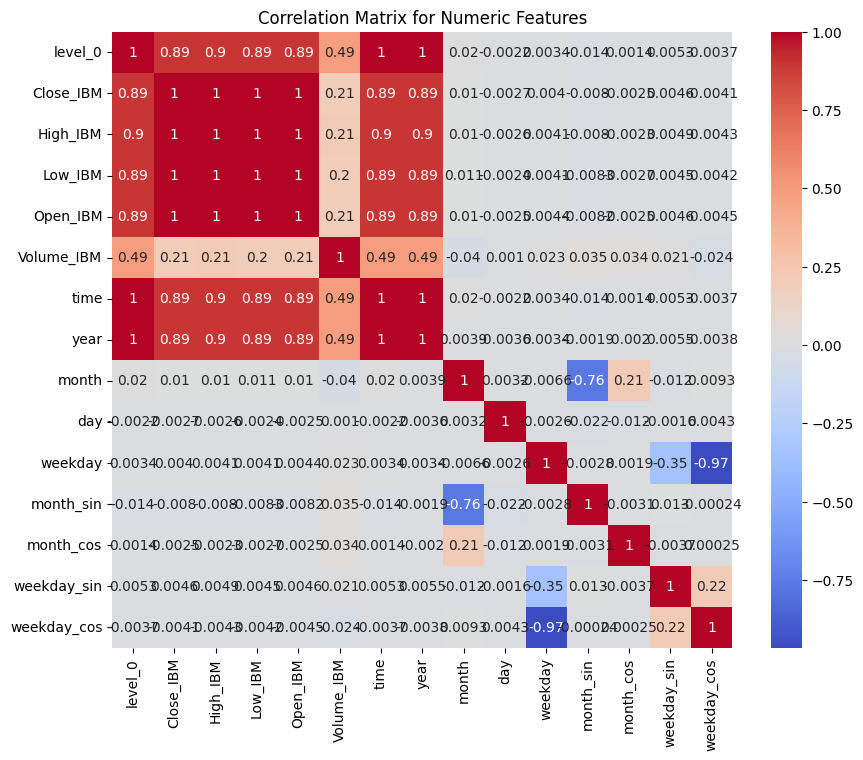

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns
numeric_data = data_ibm.select_dtypes(include=[float, int])

# Compute correlation matrix
corr_matrix = numeric_data.corr()

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Numeric Features")
plt.show()

In [5]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

X = data_ibm[['High_IBM', 'Low_IBM', 'Open_IBM', 'Volume_IBM', 'year', 
              'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos']]
y = data_ibm['Close_IBM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

feature_importance = pd.Series(lasso.coef_, index=X.columns)
print("Lasso coefficients:\n", feature_importance)

Lasso coefficients:
 High_IBM       0.486370
Low_IBM        0.199630
Open_IBM       0.000000
Volume_IBM    -0.000000
year           0.003937
month_sin     -0.000000
month_cos      0.000000
weekday_sin    0.000000
weekday_cos    0.000000
dtype: float64


In [6]:
# Create refined dataset
selected_features = ['High_IBM', 'Low_IBM', 'year']
refined_data = data_ibm[['Date', 'time', 'group', 'Close_IBM'] + selected_features].copy()

from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer

# Define parameters
max_encoder_length = 120
max_prediction_length = 30
training_cutoff = refined_data["time"].max() - max_prediction_length

# Create training dataset
training_dataset = TimeSeriesDataSet(
    refined_data[refined_data["time"] <= training_cutoff],
    time_idx="time",
    target="Close_IBM",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group"],
    static_reals=["year"],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["High_IBM", "Low_IBM", "Close_IBM"],
    target_normalizer=GroupNormalizer(
        groups=["group"],
        transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# Create validation dataset
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, 
    refined_data, 
    predict=True, 
    stop_randomization=True
)

# Create dataloaders
batch_size = 128
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [8]:
from pytorch_forecasting import TemporalFusionTransformer, QuantileLoss
import lightning.pytorch as pl
import torch
# Initialize model
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.001,
    hidden_size=128,
    attention_head_size=8,
    dropout=0.5,
    hidden_continuous_size=64,
    loss=QuantileLoss(),
    optimizer="adam",
    reduce_on_plateau_patience=2,
    weight_decay=1e-3
)

# Setup trainer
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    gradient_clip_val=0.5,
)

# Train model
trainer.fit(tft, train_dataloader, val_dataloader)

c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_con

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 117/117 [00:33<00:00,  3.44it/s, v_num=89, train_loss_step=0.00976, val_loss=0.098, train_loss_epoch=0.0108] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 117/117 [00:34<00:00,  3.41it/s, v_num=89, train_loss_step=0.00976, val_loss=0.098, train_loss_epoch=0.0108]


In [9]:
# Model evaluation and visualization
raw_predictions = tft.predict(val_dataloader)
actuals = []
for x, y in val_dataloader:
    actuals.append(y[0][:, -1])
actuals = torch.cat(actuals)
predictions = raw_predictions.mean(1)

# Convert to numpy
actuals_np = actuals.cpu().numpy()
predictions_np = predictions.cpu().numpy()

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(actuals_np, predictions_np)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals_np, predictions_np)

print(f"\nMetrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Save model
model_path = "C:/Users/deepa/OneDrive/Documents/Project Documents/Stock_Market_Forecasting_using_DeepLearning/WebApp/Models/model_ibm.pth"
torch.save(tft.state_dict(), model_path)
print(f"Model saved successfully at {model_path}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\deepa\OneDrive\Documents\Project Documents\Stock_Market_Forecasting_using_DeepLearning\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.



Metrics:
MSE: 0.0214
RMSE: 0.1463
MAE: 0.1463
Model saved successfully at C:/Users/deepa/OneDrive/Documents/Project Documents/Stock_Market_Forecasting_using_DeepLearning/WebApp/Models/model_ibm.pth
